<a href="https://colab.research.google.com/github/AliKayhanAtay/Pytorch-Mnist-Experiment/blob/main/PytorchMnistExperiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
def GetMNIST():
  import requests, gzip, os, numpy
  main_url = 'http://yann.lecun.com/exdb/mnist/'
  FileDict = {'TrainData'  : 'train-images-idx3-ubyte.gz',
              'TrainLabel' : 'train-labels-idx1-ubyte.gz',
              'TestData'   : 't10k-images-idx3-ubyte.gz',
              'TestLabel'  : 't10k-labels-idx1-ubyte.gz'}
  out = dict()
  for k, v in FileDict.items():
    if not os.path.exists(v):
      r = requests.get(main_url+v, allow_redirects=True)
      with open(v, 'wb') as f:
        f.write(r.content)
    with open(v, 'rb') as f:
      data = f.read()
      data = gzip.decompress(data)
      data = numpy.frombuffer(data, dtype=numpy.uint8)
      if 'Data' in k:
        out[k] = data[0x10:].reshape((-1,28,28))
      else:
        out[k] = data[8:]
  return out['TrainData'], out['TrainLabel'], out['TestData'], out['TestLabel']

TrainData, Trainlabel, TestData, TestLabel = GetMNIST()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
#from torchsample.callbacks import EarlyStopping

from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict

In [ ]:
class MnistNet(torch.nn.Module):
  def __init__(self):
    super(MnistNet, self).__init__()
    self.l1 = nn.Linear(784, 128)
    self.l2 = nn.Linear(128, 64)
    self.l3 = nn.Linear(64, 10)

    self.d1 = nn.Dropout(p=0.05)
    self.d2 = nn.Dropout(p=0.05)
    self.d3 = nn.Dropout(p=0.05)

  def forward(self, x):
    x = self.l1(x)
    x = self.d1(x)
    x = F.relu(x)
    x = self.l2(x)
    x = self.d2(x)
    x = F.relu(x)
    x = self.l3(x)
    x = F.log_softmax(x, dim=1) 
    return x    

In [ ]:
def Train(X_Train, y_Train, X_Test, y_Test):

  model = MnistNet()
  loss_function = nn.NLLLoss()
  optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)

  for epoch in range(EPOCH):
    epoch_loss = list()
    epoch_pred = list()
    for i in range(0, len(X_Train), BACTH_SIZE):
      X = X_Train[i:i+BACTH_SIZE]
      y = y_Train[i:i+BACTH_SIZE]

      model.zero_grad()
      raw = model(X)
      pred = torch.argmax(raw, dim=1)
      epoch_pred.extend(pred.tolist())

      loss=loss_function(raw, y)
      loss.backward()
      optim.step()
      epoch_loss.append(loss.tolist())
    
    epoch_acc = np.equal(np.array(epoch_pred),y_Train.numpy()).sum() / len(y_Train)
    epoch_loss = sum(epoch_loss) / len(epoch_loss)

    test_raw  = model(X_Test)
    test_pred = torch.argmax(test_raw, dim=1)
    test_loss = loss_function(test_raw, y_Test).item()
    test_acc  = np.equal(np.array(test_pred),y_Test.numpy()).sum() / len(y_Test) 
    
    epoch_acc = "{0:.2%}".format(epoch_acc)
    epoch_loss = '{0:.{1}f}'.format(epoch_loss, 4)
    test_acc = "{0:.2%}".format(test_acc)
    test_loss = '{0:.{1}f}'.format(test_loss, 4)

    print(f'Epoch - {str(epoch).zfill(2)} || Train->[Loss: {epoch_loss} - Accuracy: {epoch_acc}] Test->[Loss: {test_loss} - Accuracy: {test_acc}]')
  
  return epoch_pred, model

In [ ]:
X_Train = torch.from_numpy(TrainData.reshape(-1,28*28)).float()
y_Train = torch.from_numpy(Trainlabel).long()
X_Test  = torch.from_numpy(TestData.reshape(-1,28*28)).float()
y_Test  = torch.from_numpy(TestLabel).long()

EPOCH = 20
BACTH_SIZE = 32

preds, model = Train(X_Train, y_Train, X_Test, y_Test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  """Entry point for launching an IPython kernel.


Epoch - 00 || Train->[Loss: 0.4263 - Accuracy: 87.88%] Test->[Loss: 0.2525 - Accuracy: 92.11%]
Epoch - 01 || Train->[Loss: 0.2077 - Accuracy: 93.70%] Test->[Loss: 0.1988 - Accuracy: 94.02%]
Epoch - 02 || Train->[Loss: 0.1648 - Accuracy: 94.95%] Test->[Loss: 0.1777 - Accuracy: 94.56%]
Epoch - 03 || Train->[Loss: 0.1359 - Accuracy: 95.75%] Test->[Loss: 0.1537 - Accuracy: 95.40%]
Epoch - 04 || Train->[Loss: 0.1163 - Accuracy: 96.33%] Test->[Loss: 0.1564 - Accuracy: 95.44%]
Epoch - 05 || Train->[Loss: 0.1050 - Accuracy: 96.72%] Test->[Loss: 0.1398 - Accuracy: 95.74%]
Epoch - 06 || Train->[Loss: 0.0951 - Accuracy: 97.01%] Test->[Loss: 0.1405 - Accuracy: 95.98%]
Epoch - 07 || Train->[Loss: 0.0867 - Accuracy: 97.27%] Test->[Loss: 0.1320 - Accuracy: 96.22%]
Epoch - 08 || Train->[Loss: 0.0788 - Accuracy: 97.56%] Test->[Loss: 0.1267 - Accuracy: 96.25%]
Epoch - 09 || Train->[Loss: 0.0735 - Accuracy: 97.68%] Test->[Loss: 0.1328 - Accuracy: 96.18%]
Epoch - 10 || Train->[Loss: 0.0678 - Accuracy: 97.

In [ ]:
model.eval();

In [ ]:
test_pred_raw = model(X_Test)
test_pred = torch.argmax(test_pred_raw, dim=1)

In [ ]:
_ = [(idx, a.item(), b.item())for idx, (a,b) in enumerate(zip(y_Test, test_pred)) if a!=b]
preds = pd.DataFrame(_, columns=['INDEX','y_True','y_Pred'])

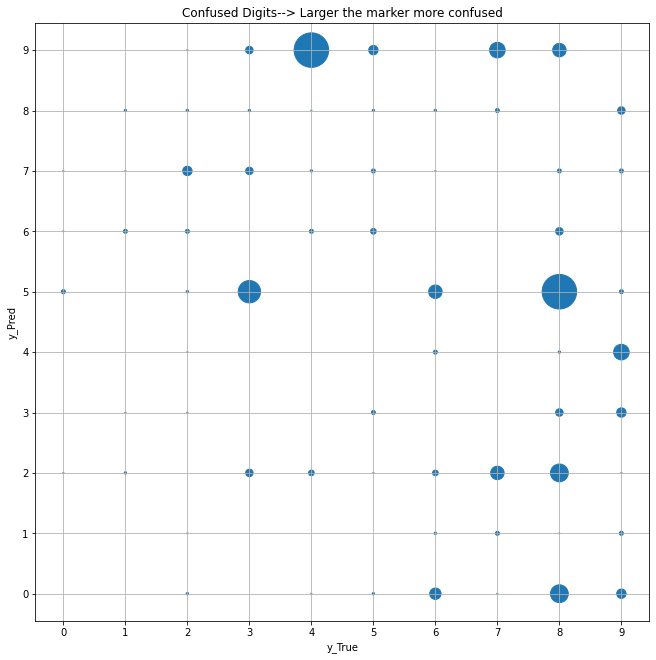

In [ ]:
confused = preds.groupby(['y_True','y_Pred'], as_index=False).size().sort_values('size',ascending=False)
fig, ax = plt.subplots(figsize=(11,11))
confused.plot.scatter('y_True','y_Pred', s=confused['size']**2.5, ax=ax)

ax.set_xticks(range(0, 10, 1))
ax.set_yticks(range(0, 10, 1))
ax.grid(True)
ax.set_title('Confused Digits--> Larger the marker more confused')
plt.show()

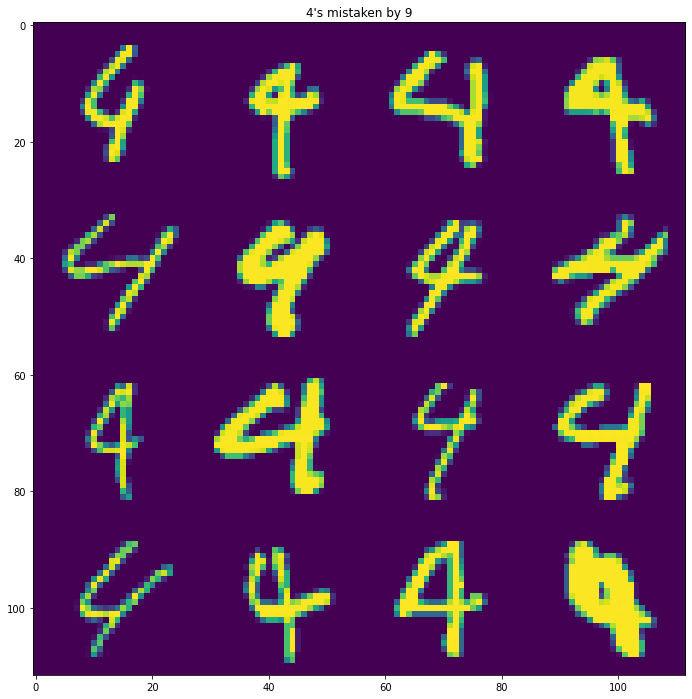

In [ ]:
most_confused = preds.merge(confused.head(1), on=['y_True',	'y_Pred'])

plt.figure(figsize=(12,12))
grid_size = int(most_confused.shape[0]**0.5)
plt.imshow(np.concatenate(X_Test[most_confused['INDEX'].tolist()][:grid_size**2].reshape((grid_size,28*grid_size,28)).numpy(), axis=1))
plt.title(f"{most_confused.y_True.tolist()[0]}'s mistaken by {most_confused.y_Pred.tolist()[0]}")
plt.show()